In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datasets import Dataset, DatasetDict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
base_dir = Path("../outputs/tta")
datasets = ['subset', 'ft_vae', 'musiccaps', 'lp-musiccaps', 'zero-shot', 'base_vae']

In [3]:
predictions = {}

for d in datasets:
    print(d)
    model_dir = base_dir / d / "per_sample_scores.csv"
    model_predictions = pd.read_csv(model_dir)
    predictions[d] = pd.DataFrame(model_predictions).head(500)
display(predictions['ft_vae'].head())

subset
ft_vae
musiccaps
lp-musiccaps
zero-shot
base_vae


,id,aspect_list,prediction,perplexity,llm_judge_score,llm_judge_reasoning,prediction_length,filename,clap_score
0,77bedd0ea9baf7f99eeb628b155da91a,"['dark', 'electronic', 'female voice', 'harsh'...",This electronic instrumental is played by a DJ...,8.507812,9.0,The description excels,360,77bedd0ea9baf7f99eeb628b155da91a.wav,0.215688
1,d2e35e60e085c8e37f9862b0fe33401b,"['bass', 'emotional', 'fast tempo', 'no voices...",The Pop song features wide electric guitar mel...,17.593750,5.0,The description attempts to incorporate most o...,287,d2e35e60e085c8e37f9862b0fe33401b.wav,0.357318
2,f86e1bdd85ef51b089a2dc51fab13f89,"['digital drums', 'emotional', 'medium to upte...",A female voice is singing in a higher pitch wh...,20.687500,8.0,The revised description more accurately reflec...,233,f86e1bdd85ef51b089a2dc51fab13f89.wav,0.009215
3,dbcc4c855f3cfa24536b29bcef93e839,"['groovy bass', 'jazz', 'male singer', 'passio...",A male vocalist sings this cool jazz. The temp...,11.757812,8.0,The description accurately incorporates the gi...,320,dbcc4c855f3cfa24536b29bcef93e839.wav,0.183224
4,3c773b0b8d4a2bb2ec6520fae68b5cca,"['electric guitar', 'energetic', 'groovy', 'gu...",This is an instrumental hip-hop/beatstep piece...,10.585938,7.0,The description is somewhat accurate and coher...,415,3c773b0b8d4a2bb2ec6520fae68b5cca.wav,0.850758


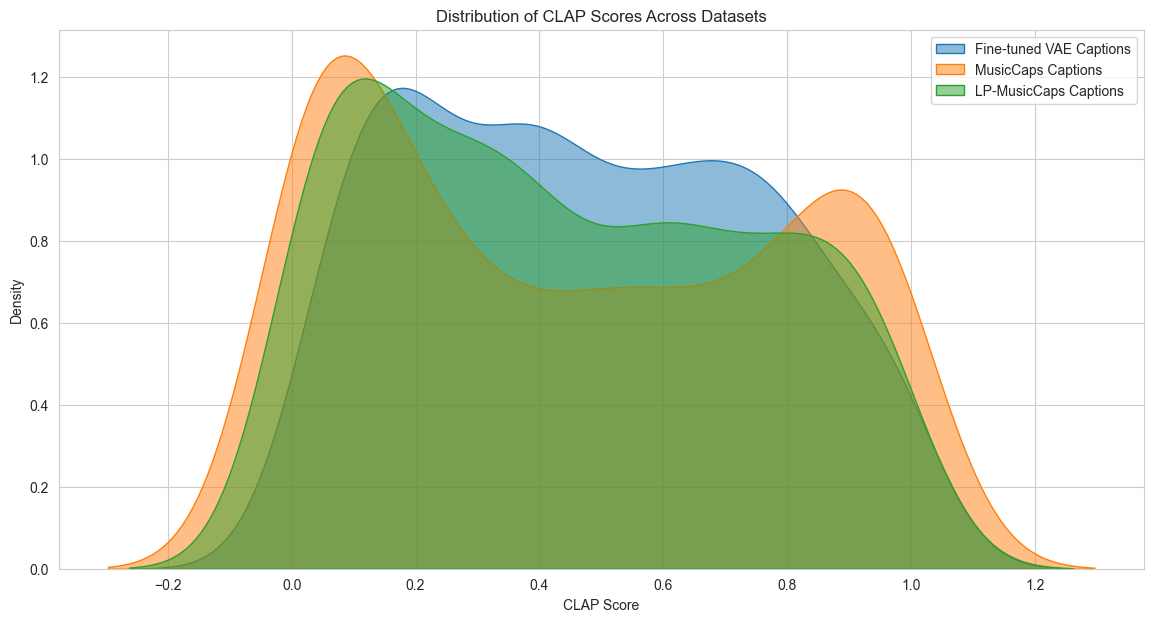

In [4]:
datasets = ['subset', 'musiccaps', 'lp-musiccaps']
labels = ['Fine-tuned VAE Captions', 'MusicCaps Captions', 'LP-MusicCaps Captions']
plt.figure(figsize=(14, 7))
for m, label in zip(datasets, labels):
    sns.kdeplot(predictions[m]['clap_score'], label=label, fill=True, alpha=0.5)
plt.title('Distribution of CLAP Scores Across Datasets')
plt.xlabel('CLAP Score')
plt.ylabel('Density')
plt.legend()
plt.show()


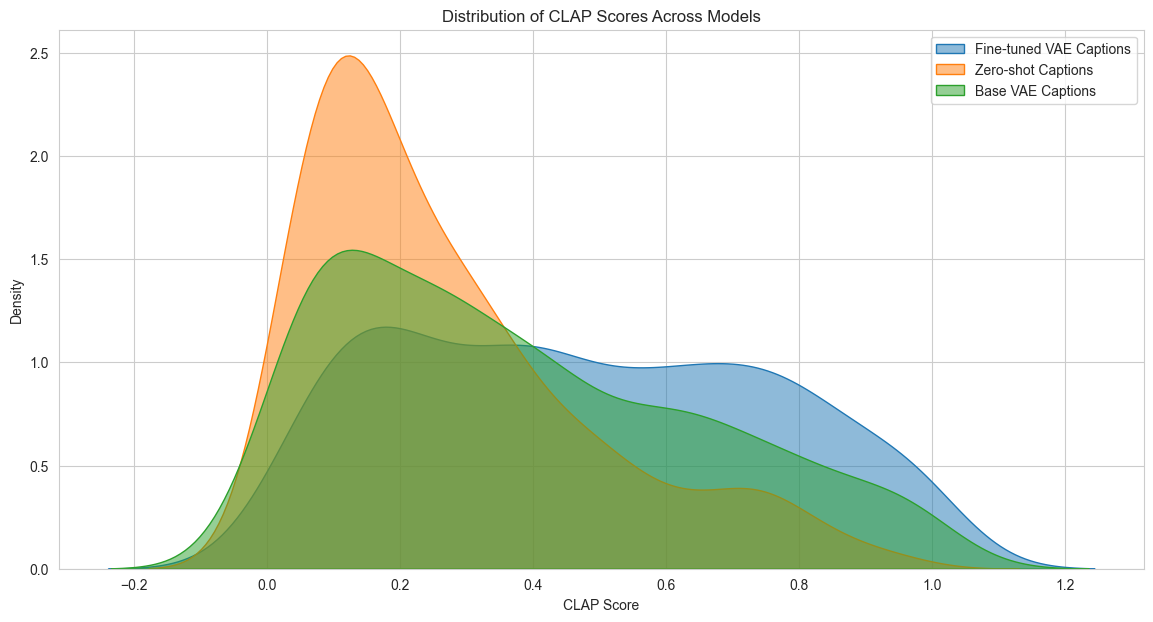

In [6]:
datasets = ['subset', 'zero-shot', 'base_vae']
labels = ['Fine-tuned VAE Captions', 'Zero-shot Captions', 'Base VAE Captions']
plt.figure(figsize=(14, 7))
for m, label in zip(datasets, labels):
    sns.kdeplot(predictions[m]['clap_score'], label=label, fill=True, alpha=0.5)
plt.title('Distribution of CLAP Scores Across Models')
plt.xlabel('CLAP Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [37]:
# Comparison visualization utilities
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

def create_grouped_bar_chart(data_dict, metrics, title, ylabel="Value", figsize=(14, 7), 
                              invert_metrics=None, colors=None):
    """
    Create grouped bar chart for comparing configurations across metrics.
    
    Args:
        data_dict: Dict with configuration names as keys and dicts of metric values
        metrics: List of metric names to plot
        title: Chart title
        ylabel: Y-axis label
        invert_metrics: List of metrics where lower is better (will be shown inverted)
        colors: List of colors for each configuration
    """
    if invert_metrics is None:
        invert_metrics = []
    
    if colors is None:
        colors = sns.color_palette("husl", len(data_dict))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(metrics))
    width = 0.8 / len(data_dict)
    
    for idx, (config, values_dict) in enumerate(data_dict.items()):
        values = [values_dict[metric] for metric in metrics]
        offset = (idx - len(data_dict)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=config, color=colors[idx], alpha=0.8)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}' if height < 1 else f'{height:.1f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11, fontweight='bold')
    ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig, ax

def create_heatmap_comparison(data_dict, metrics, title, figsize=(12, 6), 
                               cmap='RdYlGn', annot_fmt='.3f', vmin=None, vmax=None):
    """
    Create heatmap for comparing configurations across metrics.
    
    Args:
        data_dict: Dict with configuration names as keys and dicts of metric values
        metrics: List of metric names
        title: Chart title
        cmap: Colormap name
        annot_fmt: Format string for annotations
        vmin, vmax: Color scale limits
    """
    # Create DataFrame from data
    df_data = []
    for config, values_dict in data_dict.items():
        row = [values_dict[metric] for metric in metrics]
        df_data.append(row)
    
    df = pd.DataFrame(df_data, columns=metrics, index=list(data_dict.keys()))
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, fmt=annot_fmt, cmap=cmap, 
                linewidths=2, linecolor='white', cbar_kws={'label': 'Value'},
                vmin=vmin, vmax=vmax, ax=ax)
    
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
    ax.set_ylabel('Configuration', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    return fig, ax

def create_comparison_panel(data_dict, metrics, title, colors=None, figsize=(16, 6)):
    """
    Create a panel with both bar chart and heatmap side by side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Bar chart on left
    if colors is None:
        colors = sns.color_palette("husl", len(data_dict))
    
    x = np.arange(len(metrics))
    width = 0.8 / len(data_dict)
    
    for idx, (config, values_dict) in enumerate(data_dict.items()):
        values = [values_dict[metric] for metric in metrics]
        offset = (idx - len(data_dict)/2 + 0.5) * width
        bars = ax1.bar(x + offset, values, width, label=config, color=colors[idx], alpha=0.8)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}' if height < 1 else f'{height:.1f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax1.set_xlabel('Metrics', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, fontsize=10, rotation=15, ha='right')
    ax1.legend(fontsize=9, loc='upper left')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Heatmap on right
    df_data = []
    for config, values_dict in data_dict.items():
        row = [values_dict[metric] for metric in metrics]
        df_data.append(row)
    
    df = pd.DataFrame(df_data, columns=metrics, index=list(data_dict.keys()))
    sns.heatmap(df, annot=True, fmt='.3f', cmap='RdYlGn', 
                linewidths=1.5, linecolor='white', cbar_kws={'label': 'Value'},
                ax=ax2)
    
    ax2.set_xlabel('Metrics', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Configuration', fontsize=11, fontweight='bold')
    
    fig.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, (ax1, ax2)


## Conditioning Strategy Comparison

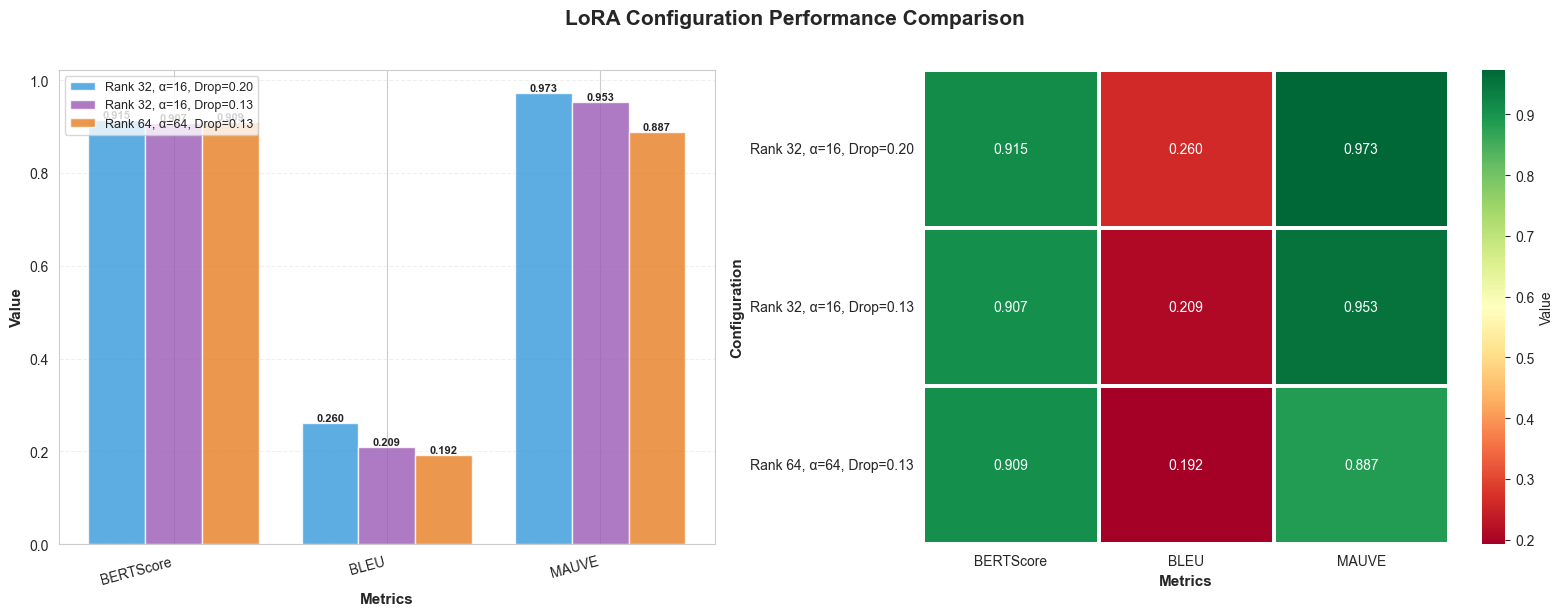


LoRA Configuration Summary:
----------------------------------------------------------------------

Rank 32, α=16, Drop=0.20:
  BERTScore: 0.9148
  BLEU: 0.2603
  MAUVE: 0.9731

Rank 32, α=16, Drop=0.13:
  BERTScore: 0.9072
  BLEU: 0.2091
  MAUVE: 0.9531

Rank 64, α=64, Drop=0.13:
  BERTScore: 0.9088
  BLEU: 0.1923
  MAUVE: 0.8873

✓ Best configuration: Rank 32, α=16, Dropout=0.20
  → Highest BERTScore (0.9148) - best semantic similarity
  → Highest BLEU (0.2603) - best n-gram overlap
  → Highest MAUVE (0.9731) - best distribution match

Insight: Moderate dropout (0.20) prevents overfitting while
         preserving caption quality better than lower dropout.


In [38]:
# Table 2: LLM fine-tuning ablation comparing LoRA configurations
lora_data = {
    'Rank 32, α=16, Drop=0.20': {
        'BERTScore': 0.9148,
        'BLEU': 0.2603,
        'MAUVE': 0.9731
    },
    'Rank 32, α=16, Drop=0.13': {
        'BERTScore': 0.9072,
        'BLEU': 0.2091,
        'MAUVE': 0.9531
    },
    'Rank 64, α=64, Drop=0.13': {
        'BERTScore': 0.9088,
        'BLEU': 0.1923,
        'MAUVE': 0.8873
    }
}

metrics_lora = ['BERTScore', 'BLEU', 'MAUVE']
colors_lora = ['#3498db', '#9b59b6', '#e67e22']

# Create comparison panel
fig, axes = create_comparison_panel(
    lora_data,
    metrics_lora,
    'LoRA Configuration Performance Comparison',
    colors=colors_lora,
    figsize=(16, 6)
)
plt.show()

# Print summary statistics
print("\nLoRA Configuration Summary:")
print("-" * 70)
for config, values in lora_data.items():
    print(f"\n{config}:")
    for metric, value in values.items():
        print(f"  {metric}: {value:.4f}")
print(f"\n✓ Best configuration: Rank 32, α=16, Dropout=0.20")
print("  → Highest BERTScore (0.9148) - best semantic similarity")
print("  → Highest BLEU (0.2603) - best n-gram overlap")
print("  → Highest MAUVE (0.9731) - best distribution match")
print("\nInsight: Moderate dropout (0.20) prevents overfitting while")
print("         preserving caption quality better than lower dropout.")


## LoRA Configuration Comparison

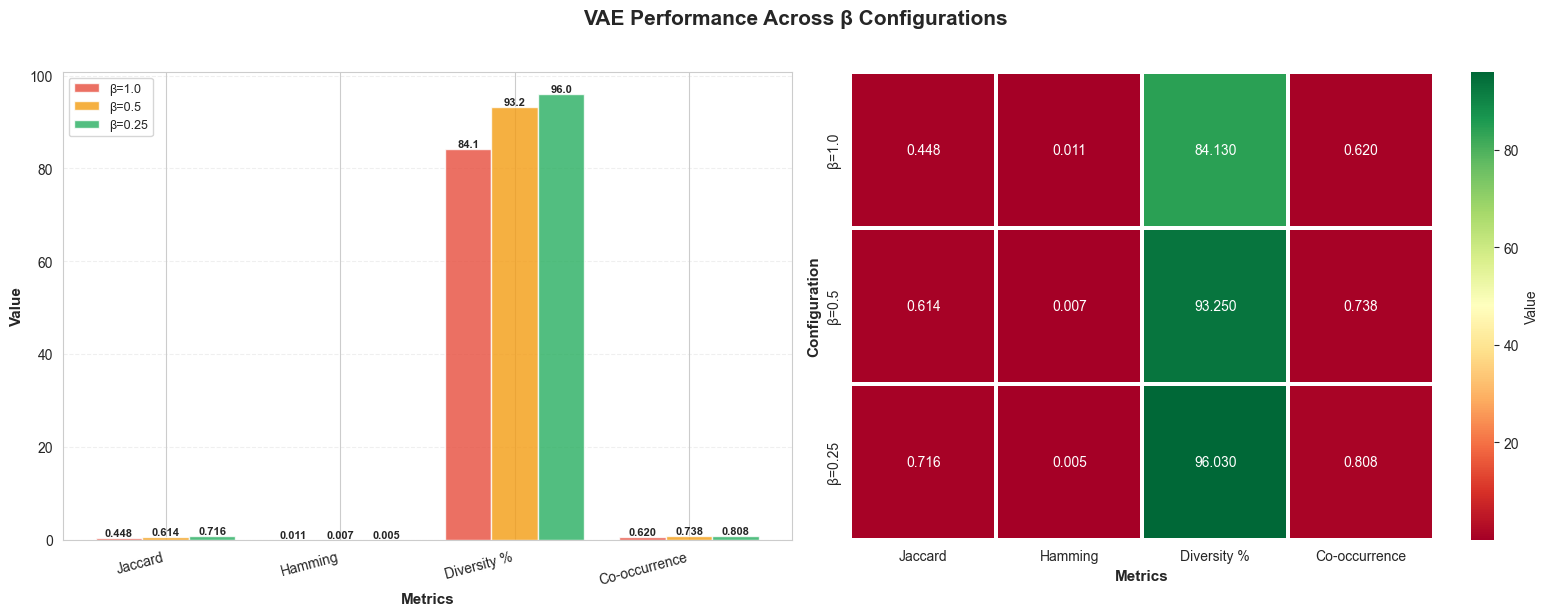


VAE Configuration Summary:
----------------------------------------------------------------------

β=1.0:
  Jaccard: 0.448
  Hamming: 0.011
  Diversity %: 84.13
  Co-occurrence: 0.62

β=0.5:
  Jaccard: 0.614
  Hamming: 0.0075
  Diversity %: 93.25
  Co-occurrence: 0.738

β=0.25:
  Jaccard: 0.716
  Hamming: 0.005
  Diversity %: 96.03
  Co-occurrence: 0.808

✓ Best configuration: β=0.25 (optimal balance)
  → Highest Jaccard (0.716) and Co-occurrence (0.808)
  → Lowest Hamming distance (0.005)
  → Best diversity (96.03%)


In [39]:
# Table 1: VAE performance across different β configurations
vae_data = {
    'β=1.0': {
        'Jaccard': 0.448,
        'Hamming': 0.011,
        'Diversity %': 84.13,
        'Co-occurrence': 0.620
    },
    'β=0.5': {
        'Jaccard': 0.614,
        'Hamming': 0.0075,
        'Diversity %': 93.25,
        'Co-occurrence': 0.738
    },
    'β=0.25': {
        'Jaccard': 0.716,
        'Hamming': 0.005,
        'Diversity %': 96.03,
        'Co-occurrence': 0.808
    }
}

metrics_vae = ['Jaccard', 'Hamming', 'Diversity %', 'Co-occurrence']
colors_vae = ['#e74c3c', '#f39c12', '#27ae60']

# Create comparison panel
fig, axes = create_comparison_panel(
    vae_data,
    metrics_vae,
    'VAE Performance Across β Configurations',
    colors=colors_vae,
    figsize=(16, 6)
)
plt.show()

# Print summary statistics
print("\nVAE Configuration Summary:")
print("-" * 70)
for config, values in vae_data.items():
    print(f"\n{config}:")
    for metric, value in values.items():
        print(f"  {metric}: {value}")
print(f"\n✓ Best configuration: β=0.25 (optimal balance)")
print("  → Highest Jaccard (0.716) and Co-occurrence (0.808)")
print("  → Lowest Hamming distance (0.005)")
print("  → Best diversity (96.03%)")
